In [1]:
import shap
import cv2
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import copy
%matplotlib inline
import skimage.segmentation
from sklearn.linear_model import LinearRegression
from skimage.color import gray2rgb
import os
from PIL import Image
import joblib

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
#importing required libraries
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

In [3]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import ipyplot

input_img = imageio.imread('xai_thyroid/Data/datapre/108_1.jpg')
rot1 = iaa.Affine(rotate=(-90))
input_rot1 = rot1.augment_image(input_img)
# images_list=[input_img, input_rot1]
# labels = ['Original', 'Rotated Image']
# ipyplot.plot_images(images_list,labels=labels,img_width=180)

In [4]:
import pandas as pd
 
# read by default 1st sheet of an excel file
# df = pd.read_excel('xai_thyroid/Data/labels.xlsx', header=0)
# df.to_csv('xai_thyroid/Data/labels.csv', index=False)
dataframe = pd.read_csv("xai_thyroid/Data/labels.csv", encoding='utf-8')
dataframe = dataframe[:480]
# print(dataframe)

dataset = []
for i in range(len(dataframe)):
    if dataframe["Cla1"][i]==0:
        continue
    row_data = []
    
    for row in dataframe:
        row_data.append(dataframe[row][i])
    dataset.append(row_data)

dataset

[['2_1', 1, '2'],
 ['3_1', 2, '4a'],
 ['4_1', 2, '4a'],
 ['5_1', 2, '5'],
 ['6_1', 2, '4b'],
 ['7_1', 2, '4a'],
 ['8_1', 2, '4c'],
 ['9_1', 2, '4b'],
 ['10_1', 2, '4b'],
 ['11_1', 2, '5'],
 ['12_1', 2, '4a'],
 ['13_1', 2, '4a'],
 ['14_1', 1, '2'],
 ['15_1', 2, '4c'],
 ['16_1', 1, '3'],
 ['17_1', 1, '2'],
 ['18_1', 2, '4a'],
 ['19_1', 2, '5'],
 ['20_1', 2, '4b'],
 ['21_1', 2, '4a'],
 ['22_1', 1, '2'],
 ['23_1', 2, '4a'],
 ['24_1', 2, '4b'],
 ['25_1', 1, '3'],
 ['26_1', 2, '4a'],
 ['27_1', 2, '4b'],
 ['28_1', 2, '4b'],
 ['29_1', 2, '5'],
 ['30_1', 2, '4c'],
 ['31_1', 1, '3'],
 ['32_1', 2, '4a'],
 ['33_1', 2, '4a'],
 ['34_1', 2, '4c'],
 ['35_1', 2, '4b'],
 ['36_1', 2, '5'],
 ['38_1', 2, '4b'],
 ['39_1', 2, '4a'],
 ['40_1', 2, '4a'],
 ['41_1', 2, '4b'],
 ['42_1', 2, '4b'],
 ['43_1', 2, '4c'],
 ['44_1', 2, '4a'],
 ['45_1', 2, '4b'],
 ['46_1', 2, '5'],
 ['47_1', 2, '4a'],
 ['48_1', 2, '4b'],
 ['49_1', 2, '4a'],
 ['50_1', 2, '4a'],
 ['51_1', 1, '2'],
 ['52_1', 2, '4a'],
 ['53_1', 2, '4c'],
 [

In [5]:
# HOG Feature Extractor

from skimage.io import imread
def features_of_single_image(img):
    resized_img = img
    resized_img = resize(img, (128*4, 64*4))
#     print(len(resized_img))
    
    #creating hog features
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=2)
    
    return fd

path = 'xai_thyroid/Data/datapre/' + "108_1" + '.jpg'
img = imread(path)
img=gray2rgb(img)
print(img.shape)
print(features_of_single_image(img))

(300, 300, 3)
[0.24227714 0.27715249 0.03653874 ... 0.10932655 0.18081159 0.        ]


In [6]:
X = []
Y = []
count = 0
for row in dataset:
    path = 'xai_thyroid/Data/datapre/' + row[0] + '.jpg'
    img = imread(path)
    img=gray2rgb(img)
    X.append(features_of_single_image(img))
    Y.append(row[1])
        
    count=count+1
    print(count)
    
print(len(X))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [7]:
print(X[0].shape)

(70308,)


In [8]:
from imblearn.over_sampling import SMOTE
smt=SMOTE()
X_n,Y_n=smt.fit_resample(X,Y)

In [9]:
print(len(X_n))
print(len(Y_n))
X=X_n
Y=Y_n

576
576


In [10]:
x1=x2=0
for x in Y_n:
    if(x==1):
        x1=x1+1
    if(x==2):
        x2=x2+1
print(x1," ",x2)

288   288


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,
                                   random_state=104, 
                                   test_size=0.2, 
                                   shuffle=True)
print(len(X_train))
print(len(X_test))

460
116


In [20]:
# import support vector classifier 
# "Support Vector Classifier"
from sklearn.svm import SVC  
clf = SVC(kernel='linear', probability=True) 
  
# fitting x samples and y classes 
clf.fit(X_train,Y_train) 

SVC(kernel='linear', probability=True)

In [21]:
for i in range(len(X_test)):
    ans=clf.predict([X_test[i]])
    if(ans[0]!=Y_test[i]):
        print(i, " ", ans[0], " ", Y_test[i])

22   2   1
26   2   1
40   1   2


In [22]:
print(len(X[0]))

70308


In [62]:
import matplotlib
import math



def test_with_single_input_7200_hot_shap(images):
    #image=skimage.io.imread(image,format='jpeg')
    num_imgs=len(images)
    result=np.zeros((num_imgs,2))
    for i in range(num_imgs):
        image=images[i]
        res=features_of_single_image(image)
        result[i] = clf.predict_proba([res])  
    return result

path = 'xai_thyroid/Data/datapre/' + "3_1" + '.jpg'
img = imread(path)
img=gray2rgb(img)
print(img.shape)
print(test_with_single_input_7200_hot_shap([img]))
res=features_of_single_image(img)
label = clf.predict([res])
label

(300, 300, 3)
[[7.85677105e-07 9.99999214e-01]]


array([2])

In [31]:
import math
a = np.random.rand()*2
math.ceil(a)

1

In [32]:
row = [X_test[0]]
print(clf.predict(row))
# Get scores
scores = clf.decision_function(row)
print(scores)
# Get probabilities
probabilities = clf.predict_proba(row)  
print(probabilities)
# Assuming you have a binary classification problem, you can extract the probability for the positive class
positive_class_probability = probabilities[0][1]
print(positive_class_probability)

[2]
[0.39887107]
[[0.02958598 0.97041402]]
0.9704140157800387


In [53]:
images = ['51_1']
filename = images[0]
# for filename in images:
pathname = r'C:/Users/tayal/Desktop/Projects/BTP Project/survey XAI/proj/proj/xai_thyroid/Data/datapre/' + filename + '.jpg'
X=matplotlib.image.imread(pathname)
# print(X)
X=gray2rgb(X)
# X=np.reshape(X,(1,300,300,3))
# X=X.astype(np.float64)
 
ans=test_with_single_input_7200_hot_shap([X])
print(ans)
        
    
print(X.shape)
res=test_with_single_input_7200_hot_shap([X])
masker = shap.maskers.Image("inpaint_telea", X.shape)
# explainer = shap.Explainer(clf)
# shap_values = explainer.shap_values(X)
explainer = shap.Explainer(test_with_single_input_7200_hot_shap, masker, output_names=['benign','malignant'])
shap_values = explainer(np.array([X]), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

# ex_filename = filename + '.bz2'
# joblib.dump(shap_values, filename=ex_filename, compress=('bz2', 9))
# shap_values1 = joblib.load(filename=ex_filename)

[[1. 0.]]
(300, 300, 3)


  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 2it [04:48, 288.09s/it]                                                                           


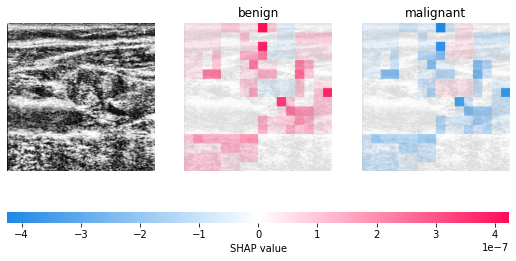

In [54]:
shap_values
shap.image_plot(shap_values/255)

[[1. 0.]]
(300, 300, 3)


  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 2it [05:00, 300.53s/it]                                                                           


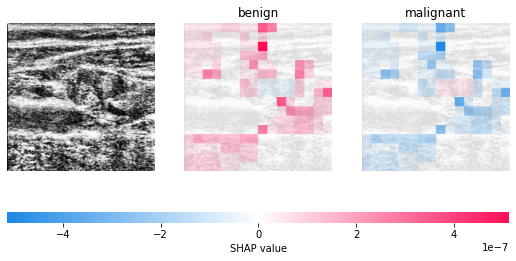

In [55]:
images = ['51_1']
filename = images[0]
# for filename in images:
pathname = r'C:/Users/tayal/Desktop/Projects/BTP Project/survey XAI/proj/proj/xai_thyroid/Data/datapre/' + filename + '.jpg'
X=matplotlib.image.imread(pathname)
# print(X)
X=gray2rgb(X)
# X=np.reshape(X,(1,300,300,3))
# X=X.astype(np.float64)
 
ans=test_with_single_input_7200_hot_shap([X])
print(ans)
        
    
print(X.shape)
res=test_with_single_input_7200_hot_shap([X])
masker = shap.maskers.Image("inpaint_telea", X.shape)
# explainer = shap.Explainer(clf)
# shap_values = explainer.shap_values(X)
explainer = shap.Explainer(test_with_single_input_7200_hot_shap, masker, output_names=['benign','malignant'])
shap_values = explainer(np.array([X]), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

shap_values
shap.image_plot(shap_values/255)

In [63]:
images = ['50_1']
filename = images[0]
# for filename in images:
pathname = r'C:/Users/tayal/Desktop/Projects/BTP Project/survey XAI/proj/proj/xai_thyroid/Data/datapre/' + filename + '.jpg'
X=matplotlib.image.imread(pathname)
# print(X)
X=gray2rgb(X)
# X=np.reshape(X,(1,300,300,3))
# X=X.astype(np.float64)
 
ans=test_with_single_input_7200_hot_shap([X])
print(ans)
        
    
print(X.shape)
res=test_with_single_input_7200_hot_shap([X])
masker = shap.maskers.Image("inpaint_telea", X.shape)
# explainer = shap.Explainer(clf)
# shap_values = explainer.shap_values(X)
explainer = shap.Explainer(test_with_single_input_7200_hot_shap, masker, output_names=['benign','malignant'])
shap_values = explainer(np.array([X]), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

# ex_filename = filename + '.bz2'
# joblib.dump(shap_values, filename=ex_filename, compress=('bz2', 9))
# shap_values1 = joblib.load(filename=ex_filename)

[[7.88521715e-07 9.99999211e-01]]
(300, 300, 3)


  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 2it [04:37, 277.24s/it]                                                                           


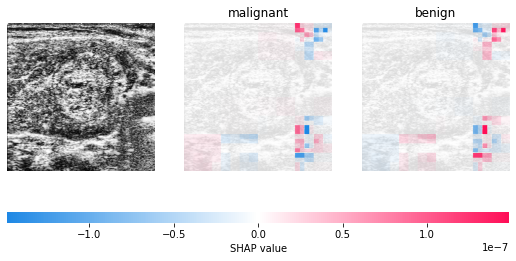

In [64]:
shap_values
shap.image_plot(shap_values/255)

In [66]:
images = ['3_1']
filename = images[0]
# for filename in images:
pathname =r'C:/Users/tayal/Desktop/Projects/BTP Project/survey XAI/proj/proj/xai_thyroid/Data/datapre/' + filename + '.jpg'
X=matplotlib.image.imread(pathname)
# print(X)
X=gray2rgb(X)
# X=np.reshape(X,(1,300,300,3))
# X=X.astype(np.float64)
 
ans=test_with_single_input_7200_hot_shap([X])
print(ans)
        
    
print(X.shape)
res=test_with_single_input_7200_hot_shap([X])
masker = shap.maskers.Image("inpaint_telea", X.shape)
# explainer = shap.Explainer(clf)
# shap_values = explainer.shap_values(X)
explainer = shap.Explainer(test_with_single_input_7200_hot_shap, masker, output_names=['benign','malignant'])
shap_values = explainer(np.array([X]), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

# ex_filename = filename + '.bz2'
# joblib.dump(shap_values, filename=ex_filename, compress=('bz2', 9))
# shap_values1 = joblib.load(filename=ex_filename)

[[7.85677105e-07 9.99999214e-01]]
(300, 300, 3)


  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 2it [04:39, 279.54s/it]                                                                           


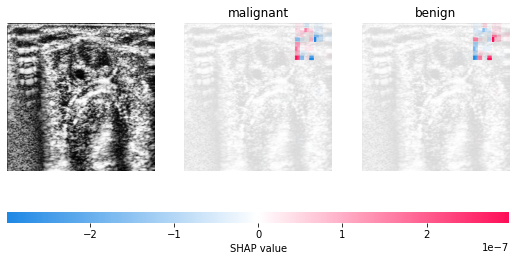

In [67]:
shap_values
shap.image_plot(shap_values/255)

In [68]:
images = ['2_1']
filename = images[0]
# for filename in images:
pathname = r'C:/Users/tayal/Desktop/Projects/BTP Project/survey XAI/proj/proj/xai_thyroid/Data/datapre/' + filename + '.jpg'
X=matplotlib.image.imread(pathname)
# print(X)
X=gray2rgb(X)
# X=np.reshape(X,(1,300,300,3))
# X=X.astype(np.float64)
 
ans=test_with_single_input_7200_hot_shap([X])
print(ans)
        
    
print(X.shape)
res=test_with_single_input_7200_hot_shap([X])
masker = shap.maskers.Image("inpaint_telea", X.shape)
# explainer = shap.Explainer(clf)
# shap_values = explainer.shap_values(X)
explainer = shap.Explainer(test_with_single_input_7200_hot_shap, masker, output_names=['benign','malignant'])
shap_values = explainer(np.array([X]), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

# ex_filename = filename + '.bz2'
# joblib.dump(shap_values, filename=ex_filename, compress=('bz2', 9))
# shap_values1 = joblib.load(filename=ex_filename)

[[0.99755764 0.00244236]]
(300, 300, 3)


  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 2it [04:22, 262.90s/it]                                                                           


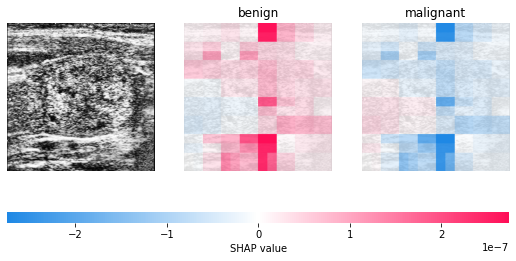

In [69]:
shap_values
shap.image_plot(shap_values/255)

In [ ]:
ex_filename = "SVM Model Results/" + filename + '.bz2'
joblib.dump(shap_values, filename=ex_filename, compress=('bz2', 9))
shap_values1 = joblib.load(filename=ex_filename)

In [6]:
X = []
Y = []
count = 0
for row in dataset:
#     path = 'xai_thyroid/Data/datapre/' + row[0] + '.jpg'
#     img = imread(path)
#     img=gray2rgb(img)
#     X.append(features_of_single_image(img))
#     Y.append(row[1])
    count=count+1
    print(count)
    print(row[0])
    if count<301:
        continue
    
    filename=row[0]
    pathname = r'C:/Users/tayal/Desktop/Projects/BTP Project/survey XAI/proj/proj/xai_thyroid/Data/datapre/' + filename + '.jpg'
    X=matplotlib.image.imread(pathname)
    X=gray2rgb(X)

    ans=test_with_single_input_7200_hot_shap([X])
    
    res=test_with_single_input_7200_hot_shap([X])
    masker = shap.maskers.Image("inpaint_telea", X.shape)
    explainer = shap.Explainer(test_with_single_input_7200_hot_shap, masker, output_names=['benign','malignant'])
    shap_values = explainer(np.array([X]), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

    ex_filename = "HOG-SVM Model Results/" + str(row[1]) + "/" + filename + '.bz2'
    print(ex_filename)
    joblib.dump(shap_values, filename=ex_filename, compress=('bz2', 9))
    shap_values1 = joblib.load(filename=ex_filename)
    shap_values
    shap.image_plot(shap_values/255)
    

NameError: name 'dataset' is not defined

In [70]:
shap_values

.values =
array([[[[[ 3.60687904e-06, -3.60687904e-06],
          [ 3.60687904e-06, -3.60687904e-06],
          [ 3.60687904e-06, -3.60687904e-06]],

         [[ 3.60687904e-06, -3.60687904e-06],
          [ 3.60687904e-06, -3.60687904e-06],
          [ 3.60687904e-06, -3.60687904e-06]],

         [[ 3.60687904e-06, -3.60687904e-06],
          [ 3.60687904e-06, -3.60687904e-06],
          [ 3.60687904e-06, -3.60687904e-06]],

         ...,

         [[ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00]],

         [[ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00]],

         [[ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00]]],


        [[[ 3.60687904e-06, -3.60687904e-06],
          [ 3.60687904e-06, -3.60687904e-06],
          [ 3.60687904e-06, -3.60687904e-

In [1]:
X = []
Y = []
count = 0
for row in dataset:
    count=count+1
    print(count)
    print(row[0])
    if count>50:
        break
    
    filename=row[0]
    pathname = r'C:/Users/tayal/Desktop/Projects/BTP Project/survey XAI/proj/proj/xai_thyroid/Data/datapre/' + filename + '.jpg'
    X=matplotlib.image.imread(pathname)
    X=gray2rgb(X)

    ans=test_with_single_input_7200_hot_shap([X])
    
    res=test_with_single_input_7200_hot_shap([X])
    masker = shap.maskers.Image("inpaint_ns", X.shape)
    explainer = shap.Explainer(test_with_single_input_7200_hot_shap, masker, output_names=['benign','malignant'])
    shap_values = explainer(np.array([X]), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

    ex_filename = "HOT-SVM inpaint_ns Masker Model Results/" + str(row[1]) + "/" + filename + '.bz2'
    print(ex_filename)
    joblib.dump(shap_values, filename=ex_filename, compress=('bz2', 9))
    shap_values1 = joblib.load(filename=ex_filename)
    shap_values
    shap.image_plot(shap_values/255)
    

NameError: name 'dataset' is not defined

In [2]:
X = []
Y = []
count = 0
for row in dataset:
    count=count+1
    print(count)
    print(row[0])
    if count>50:
        break
    
    filename=row[0]
    pathname = r'C:/Users/tayal/Desktop/Projects/BTP Project/survey XAI/proj/proj/xai_thyroid/Data/datapre/' + filename + '.jpg'
    X=matplotlib.image.imread(pathname)
    X=gray2rgb(X)

    ans=test_with_single_input_7200_hot_shap([X])
    
    res=test_with_single_input_7200_hot_shap([X])
    masker = shap.maskers.Image("blur(28,28)", X.shape)
    explainer = shap.Explainer(test_with_single_input_7200_hot_shap, masker, output_names=['benign','malignant'])
    shap_values = explainer(np.array([X]), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

    ex_filename = "HOT-SVM blur(28,28) masker Model Results/" + str(row[1]) + "/" + filename + '.bz2'
    print(ex_filename)
    joblib.dump(shap_values, filename=ex_filename, compress=('bz2', 9))
    shap_values1 = joblib.load(filename=ex_filename)
    shap_values
    shap.image_plot(shap_values/255)
    

NameError: name 'dataset' is not defined

In [3]:
X = []
Y = []
count = 0
for row in dataset:
    count=count+1
    print(count)
    print(row[0])
    if count>10:
        break
    
    filename=row[0]
    pathname = r'C:/Users/tayal/Desktop/Projects/BTP Project/survey XAI/proj/proj/xai_thyroid/Data/datapre/' + filename + '.jpg'
    X=matplotlib.image.imread(pathname)
    X=gray2rgb(X)

    ans=test_with_single_input_7200_hot_shap([X])
    
    res=test_with_single_input_7200_hot_shap([X])
    masker = shap.maskers.Image("inpaint_telea", X.shape)
    explainer = shap.Explainer(test_with_single_input_7200_hot_shap, masker, output_names=['benign','malignant'])
    shap_values = explainer(np.array([X]), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

#     ex_filename = "HOT-SVM blur(28,28) masker Model Results/" + str(row[1]) + "/" + filename + '.bz2'
#     print(ex_filename)
#     joblib.dump(shap_values, filename=ex_filename, compress=('bz2', 9))
#     shap_values1 = joblib.load(filename=ex_filename)
    shap_values
    shap.image_plot(shap_values/255)
    

NameError: name 'dataset' is not defined

In [4]:
X = []
Y = []
count = 0
for row in dataset:
    count=count+1
    print(count)
    print(row[0])
    if count>10:
        break
    
    filename=row[0]
    pathname = r'C:/Users/tayal/Desktop/Projects/BTP Project/survey XAI/proj/proj/xai_thyroid/Data/datapre/' + filename + '.jpg'
    X=matplotlib.image.imread(pathname)
    X=gray2rgb(X)

    ans=test_with_single_input_7200_hot_shap([X])
    
    res=test_with_single_input_7200_hot_shap([X])
    masker = shap.maskers.Image("inpaint_ns", X.shape)
    explainer = shap.Explainer(test_with_single_input_7200_hot_shap, masker, output_names=['benign','malignant'])
    shap_values = explainer(np.array([X]), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

#     ex_filename = "HOT-SVM blur(28,28) masker Model Results/" + str(row[1]) + "/" + filename + '.bz2'
#     print(ex_filename)
#     joblib.dump(shap_values, filename=ex_filename, compress=('bz2', 9))
#     shap_values1 = joblib.load(filename=ex_filename)
    shap_values
    shap.image_plot(shap_values/255)
    

NameError: name 'dataset' is not defined

In [5]:
X = []
Y = []
count = 0
for row in dataset:
    count=count+1
    print(count)
    print(row[0])
    if count>10:
        break
    
    filename=row[0]
    pathname = r'C:/Users/tayal/Desktop/Projects/BTP Project/survey XAI/proj/proj/xai_thyroid/Data/datapre/' + filename + '.jpg'
    X=matplotlib.image.imread(pathname)
    X=gray2rgb(X)

    ans=test_with_single_input_7200_hot_shap([X])
    
    res=test_with_single_input_7200_hot_shap([X])
    masker = shap.maskers.Image("blur(28,28)", X.shape)
    explainer = shap.Explainer(test_with_single_input_7200_hot_shap, masker, output_names=['benign','malignant'])
    shap_values = explainer(np.array([X]), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

#     ex_filename = "HOT-SVM blur(28,28) masker Model Results/" + str(row[1]) + "/" + filename + '.bz2'
#     print(ex_filename)
#     joblib.dump(shap_values, filename=ex_filename, compress=('bz2', 9))
#     shap_values1 = joblib.load(filename=ex_filename)
    shap_values
    shap.image_plot(shap_values/255)
    

NameError: name 'dataset' is not defined